In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from transformers import AutoTokenizer, AutoModel
from multiprocessing import Pool

import lightgbm as lgb

from torch.utils.data import DataLoader
import torch
from torch.optim import Adam
from tqdm import tqdm

import random
import numpy as np

import re
import nltk
import string
import numpy as np
from torch.utils.data import Dataset
from torch import nn

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load and split datasets

In [2]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)


print("*************** SAMPLE SUBMISSION *****************")
display(sample_submission)

print("\n*************** TRAIN DATA *****************")
display(train_df)

print("\n*************** VAL DATA *****************")
display(val_df)

print("\n*************** TEST DATA *****************")
display(test_df)

*************** SAMPLE SUBMISSION *****************


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0



*************** TRAIN DATA *****************


,id,keyword,location,text,target
4996,7128,military,Texas,Courageous and honest analysis of need to use ...,1
3263,4688,engulfed,NaN,@ZachZaidman @670TheScore wld b a shame if tha...,0
4907,6984,massacre,Cottonwood Arizona,Tell @BarackObama to rescind medals of 'honor'...,1
2855,4103,drought,"Spokane, WA",Worried about how the CA drought might affect ...,1
4716,6706,lava,"Medan,Indonesia",@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1



*************** VAL DATA *****************


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
1835,2640,crashed,Somewhere,@SmusX16475 Skype just crashed u host,0
506,731,attacked,Arundel,Christian Attacked by Muslims at the Temple Mo...,1
3592,5131,fatal,"New South Wales, Australia",Man charged over fatal crash near Dubbo refuse...,1
6740,9657,thunderstorm,NaN,#usNWSgov Severe Weather Statement issued Augu...,1



*************** TEST DATA *****************


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 4996 to 7270
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6090 non-null   int64 
 1   keyword   6042 non-null   object
 2   location  4070 non-null   object
 3   text      6090 non-null   object
 4   target    6090 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 285.5+ KB


In [4]:
def reset_random_state():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    
reset_random_state()

## Keyword Ranking
Find correlation between the keyword and the likelihood of a disaster

In [5]:
train_keywords = train_df.groupby(["keyword"], dropna=False)["text"].count().to_frame().rename(columns={"text": "count"})

train_keywords["disaster"] = train_df[train_df["target"] == 1].groupby(["keyword"], dropna=False)["text"].count()
train_keywords["non_disaster"] = train_df[train_df["target"] == 0].groupby(["keyword"], dropna=False)["text"].count()
train_keywords = train_keywords.fillna(0)
train_keywords["ratio"] = train_keywords["disaster"] / train_keywords["count"]

#train_keywords = train_keywords.sort_values(by=["ratio"])

train_keywords

,count,disaster,non_disaster,ratio
keyword,,,,
ablaze,27,8.0,19.0,0.296296
accident,22,14.0,8.0,0.636364
aftershock,29,0.0,29.0,0.000000
airplane%20accident,29,26.0,3.0,0.896552
ambulance,28,16.0,12.0,0.571429
...,...,...,...,...
wounds,30,9.0,21.0,0.300000
wreck,29,5.0,24.0,0.172414
wreckage,35,35.0,0.0,1.000000


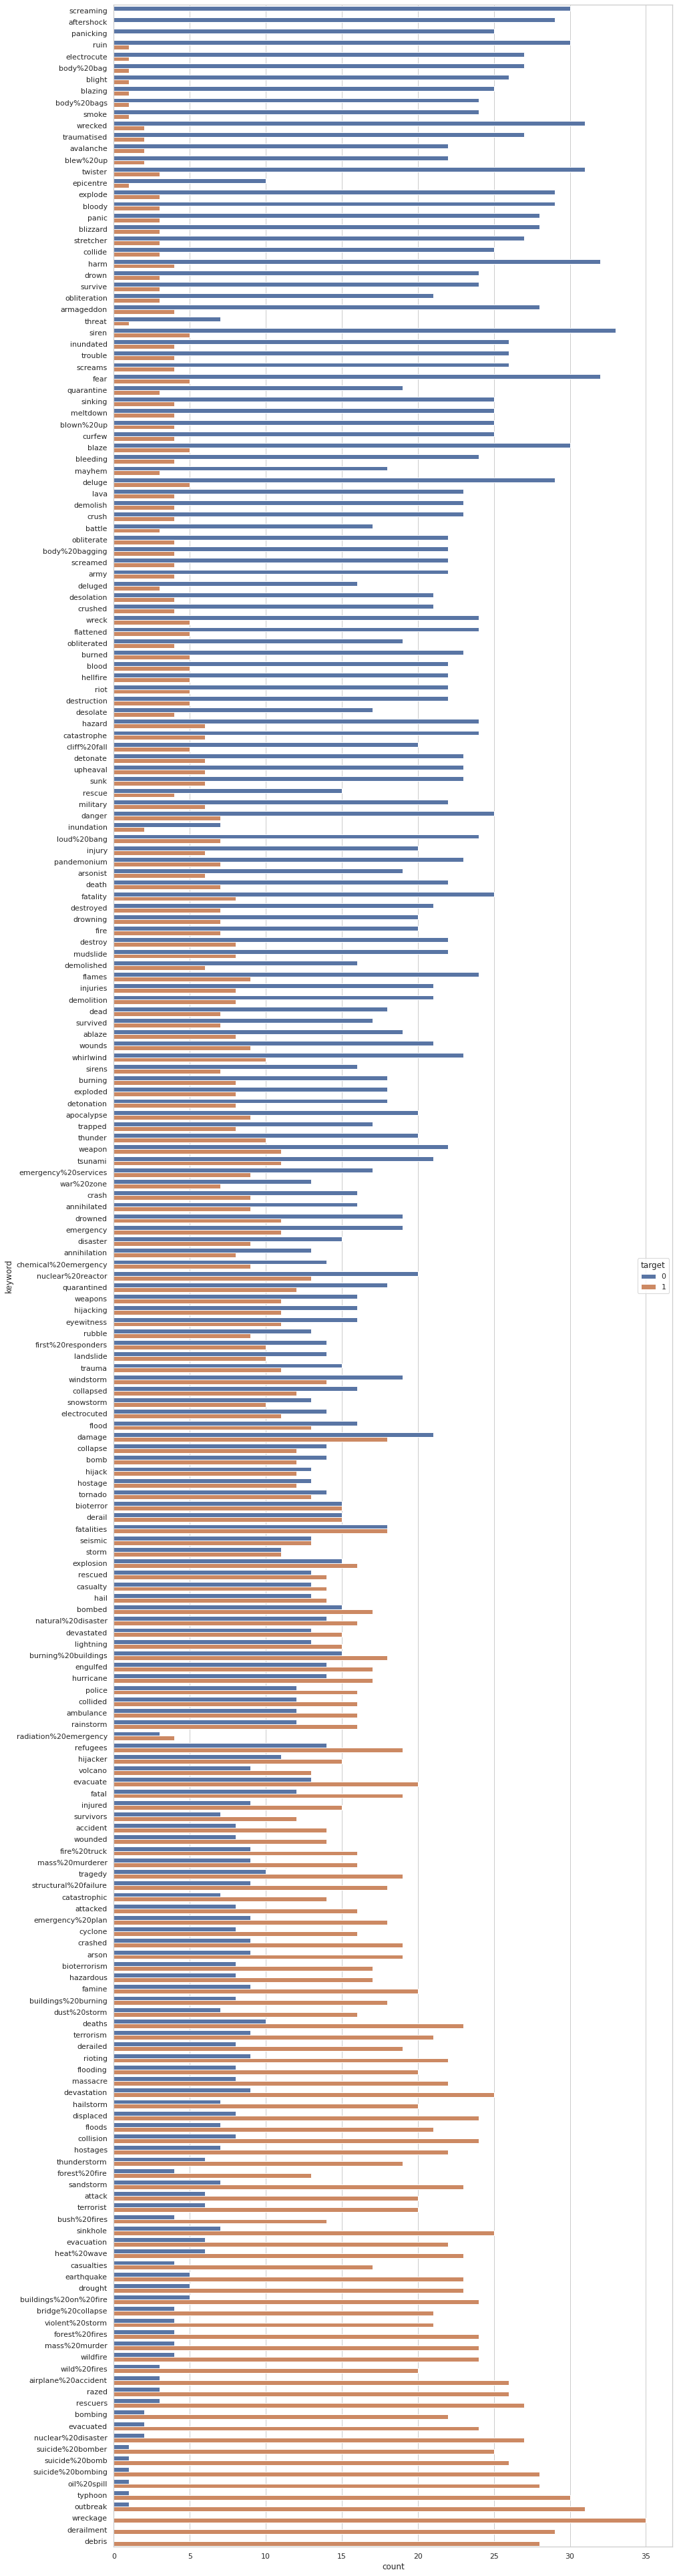

In [6]:
train_df["keyword_disaster_ratio"] = train_df["keyword"].apply(lambda x: train_keywords.loc[x]["ratio"])
train_df["keyword_disaster_ratio_count"] = train_df["keyword"].apply(lambda x: train_keywords.loc[x]["count"])

val_df["keyword_disaster_ratio"] = val_df["keyword"].apply(lambda x: train_keywords.loc[x]["ratio"])
val_df["keyword_disaster_ratio_count"] = val_df["keyword"].apply(lambda x: train_keywords.loc[x]["count"])

test_df["keyword_disaster_ratio"] = test_df["keyword"].apply(lambda x: train_keywords.loc[x]["ratio"])
test_df["keyword_disaster_ratio_count"] = test_df["keyword"].apply(lambda x: train_keywords.loc[x]["count"])


train_df = train_df.sort_values(by=["keyword_disaster_ratio"])


fig, ax = plt.subplots(figsize=(15,70))
sns.countplot(data=train_df, y="keyword", hue="target", ax=ax)

train_df = train_df.drop(["keyword"], axis=1)
val_df = val_df.drop(["keyword"], axis=1)
test_df = test_df.drop(["keyword"], axis=1)

## Locations

In [7]:
#def clean_up_locations(df):
#    df["location"] = df['location'].str.replace('[^a-zA-Z\d\s]', '', regex=True)
#    df["location"] = df['location'].str.replace('\\n', '', regex=False)

#    df["location"] = df['location'].str.replace('California USA', 'California', regex=False)
#    df["location"] = df['location'].str.replace('Chicago IL', 'Chicago', regex=False)

#    df["location"] = df["location"].replace("Earth", "Worldwide", regex=False)
#    df["location"] = df["location"].replace("Everywhere", "Worldwide", regex=False)
#    df["location"] = df["location"].replace("Global", "Worldwide", regex=False)


#    df["location"] = df["location"].replace("NYC", "New York", regex=False)
#    df["location"] = df["location"].replace("New York NY", "New York", regex=False)
#    df["location"] = df["location"].replace("New York City", "New York", regex=False)


#    df["location"] = df["location"].replace("United Kingdom", "UK", regex=False)
#    df["location"] = df["location"].replace("United States", "USA", regex=False)
#    df["location"] = df["location"].replace("US", "USA", regex=False)

#    df["location"] = df["location"].replace("London UK", "London", regex=False)
#    df["location"] = df["location"].replace("San Francisco CA", "San Francisco", regex=False)
#    df["location"] = df["location"].replace("Los Angeles CA", "Los Angeles", regex=False)

#    df["location"] = df["location"].replace("Seattle WA", "Seattle", regex=False)

#    df["location"] = df["location"].replace("^\s*$", np.NaN, regex=True)
    
#    return df

#train_df = clean_up_locations(train_df)
#val_df = clean_up_locations(val_df)
#test_df = clean_up_locations(test_df)

#train_locations = train_df.groupby(["location"], dropna=False)["text"].count().to_frame().rename(columns={"text": "count"})
#train_locations[train_locations["count"] > 5]

In [8]:
#train_locations = train_df.groupby(["location"], dropna=False)["text"].count().to_frame().rename(columns={"text": "count"})

#train_locations["disaster"] = train_df[train_df["target"] == 1].groupby(["location"], dropna=False)["text"].count()
#train_locations["non_disaster"] = train_df[train_df["target"] == 0].groupby(["location"], dropna=False)["text"].count()
#train_locations = train_locations.fillna(0)
#train_locations["ratio"] = train_locations["disaster"] / train_locations["count"]

#train_locations = train_locations.sort_values(by=["count"], ascending=False)

#train_locations

In [9]:
#train_df["location_disaster_ratio"] = train_df["location"].apply(lambda x: train_locations.loc[x]["ratio"])
#train_df["location_disaster_ratio_count"] = train_df["location"].apply(lambda x: train_locations.loc[x]["count"])

#val_df["location_disaster_ratio"] = val_df["location"].apply(lambda x: train_locations.loc[x]["ratio"] if x in train_locations.index else .5)
#val_df["location_disaster_ratio_count"] = val_df["location"].apply(lambda x: train_locations.loc[x]["count"] if x in train_locations.index else 0)

#test_df["location_disaster_ratio"] = test_df["location"].apply(lambda x: train_locations.loc[x]["ratio"] if x in train_locations.index else .5)
#test_df["location_disaster_ratio_count"] = test_df["location"].apply(lambda x: train_locations.loc[x]["count"] if x in train_locations.index else 0)

train_df = train_df.drop(["location"], axis=1)
val_df = val_df.drop(["location"], axis=1)
test_df = test_df.drop(["location"], axis=1)

# Final data check

In [10]:
train_df

,id,text,target,keyword_disaster_ratio,keyword_disaster_ratio_count
5976,8533,@blanksocietyx @emmerdale IM SCREAMING HES MY ...,0,0.0,30.0
122,175,That moment when you get on a scary roller coa...,0,0.0,29.0
5953,8504,@camilacabello97 NOW IM INTERNALLY SCREAMING,0,0.0,30.0
5421,7737,When he lets you drive his truck and you start...,0,0.0,25.0
5423,7739,People are finally panicking about cable TV ht...,0,0.0,25.0
...,...,...,...,...,...
2167,3108,Confirmed the debris from MH370 ??,1,1.0,28.0
7508,10739,MH370 victim's family furious the media was to...,1,1.0,35.0
7530,10768,Wreckage is MH370: Najib\nhttp://t.co/iidKC0jS...,1,1.0,35.0
2192,3140,Debris confirmed from MH370; relatives hope fo...,1,1.0,28.0


# BERT Text Classification
## Dataset Class with text preprocessing

In [11]:
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        texts = dataframe.text.values.tolist()

        texts = [self._preprocess(text) for text in texts]

        self._print_random_samples(texts)

        self.texts = [tokenizer(text, padding='max_length',
                                max_length=150,
                                truncation=True,
                                return_tensors="pt")
                      for text in texts]

        if 'target' in dataframe:
            classes = dataframe.target.values.tolist()
            self.labels = classes

    def _print_random_samples(self, texts):
        np.random.seed(42)
        random_entries = np.random.randint(0, len(texts), 5)

        for i in random_entries:
            print(f"Entry {i}: {texts[i]}")

        print()

    def _preprocess(self, text):
        text = self._remove_amp(text)
        text = self._remove_links(text)
        text = self._remove_hashes(text)
        text = self._remove_retweets(text)
        text = self._remove_mentions(text)
        text = self._remove_multiple_spaces(text)

        #text = self._lowercase(text)
        text = self._remove_punctuation(text)
        #text = self._remove_numbers(text)

        text_tokens = self._tokenize(text)
        text_tokens = self._stopword_filtering(text_tokens)
        #text_tokens = self._stemming(text_tokens)
        text = self._stitch_text_tokens_together(text_tokens)

        return text.strip()


    def _remove_amp(self, text):
        return text.replace("&amp;", " ")

    def _remove_mentions(self, text):
        return re.sub(r'(@.*?)[\s]', ' ', text)
    
    def _remove_multiple_spaces(self, text):
        return re.sub(r'\s+', ' ', text)

    def _remove_retweets(self, text):
        return re.sub(r'^RT[\s]+', ' ', text)

    def _remove_links(self, text):
        return re.sub(r'https?:\/\/[^\s\n\r]+', ' ', text)

    def _remove_hashes(self, text):
        return re.sub(r'#', ' ', text)

    def _stitch_text_tokens_together(self, text_tokens):
        return " ".join(text_tokens)

    def _tokenize(self, text):
        return nltk.word_tokenize(text, language="english")

    def _stopword_filtering(self, text_tokens):
        stop_words = nltk.corpus.stopwords.words('english')

        return [token for token in text_tokens if token not in stop_words]

    def _stemming(self, text_tokens):
        porter = nltk.stem.porter.PorterStemmer()
        return [porter.stem(token) for token in text_tokens]

    def _remove_numbers(self, text):
        return re.sub(r'\d+', ' ', text)

    def _lowercase(self, text):
        return text.lower()

    def _remove_punctuation(self, text):
        return ''.join(character for character in text if character not in string.punctuation)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        label = -1
        if hasattr(self, 'labels'):
            label = self.labels[idx]

        return text, label


## Classifier incorporating BERT

In [12]:
class TweetClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()

        self.bert = base_model
        self.fc1 = nn.Linear(768, 32)
        self.fc2 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask)[0][:, 0]
        x = self.fc1(bert_out)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

## Train & Validation loop

In [13]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    best_val_loss = 99999999999999
    early_stopping_threshold_count = 0
    
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        model.train()
        
        for train_input, train_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)

            train_label = train_label.to(device)

            output = model(input_ids, attention_mask)

            loss = criterion(output, train_label.float().unsqueeze(1))

            total_loss_train += loss.item()

            acc = ((output >= 0.5).int() == train_label.unsqueeze(1)).sum().item()
            total_acc_train += acc

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():
            total_acc_val = 0
            total_loss_val = 0
            
            model.eval()
            
            for val_input, val_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                val_label = val_label.to(device)

                output = model(input_ids, attention_mask)

                loss = criterion(output, val_label.float().unsqueeze(1))

                total_loss_val += loss.item()

                acc = ((output >= 0.5).int() == val_label.unsqueeze(1)).sum().item()
                total_acc_val += acc
            
            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .3f} '
                  f'| Train Accuracy: {total_acc_train / (len(train_dataloader.dataset)): .3f} '
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .3f} '
                  f'| Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            
            if best_val_loss > total_loss_val:
                best_val_loss = total_loss_val
                torch.save(model, f"best_model.pt")
                print("Saved model")
                early_stopping_threshold_count = 0
            else:
                early_stopping_threshold_count += 1
                
            if early_stopping_threshold_count >= 1:
                print("Early stopping")
                break

In [14]:
reset_random_state()

BERT_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
base_model = AutoModel.from_pretrained(BERT_MODEL)

train_dataloader = DataLoader(TweetDataset(train_df, tokenizer), batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(TweetDataset(val_df, tokenizer), batch_size=8, num_workers=0)

model = TweetClassifier(base_model)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Entry 860: I presume timeline inundated soggy bottom lashings moist tweets D
Entry 5390: Heat wave ending Watching big area rain thoughwill impact part area Details NOW NBC10 5pm
Entry 5226: Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
Entry 5191: USFS acronym United States Fire Service
Entry 3772: Three beached whales rescued Kerry

Entry 1126: They didnt succeed two times either Bomb didnt detonate Shots missed
Entry 1459: Nobody remembers came second Charles Schulz
Entry 860: Near sand half sunk shattered visage lies
Entry 1294: understanding umntu wakho If trust partner OK u know wont fear anything
Entry 1130: My back sunburned



In [15]:
reset_random_state()

learning_rate = 1e-5
epochs = 5
train(model, train_dataloader, val_dataloader, learning_rate, epochs)

100%|██████████| 191/191 [00:07<00:00, 24.21it/s]


Epochs: 1 | Train Loss:  0.471 | Train Accuracy:  0.786 | Val Loss:  0.427 | Val Accuracy:  0.818
Saved model


100%|██████████| 191/191 [00:07<00:00, 24.29it/s]


Epochs: 2 | Train Loss:  0.372 | Train Accuracy:  0.844 | Val Loss:  0.378 | Val Accuracy:  0.842
Saved model


100%|██████████| 191/191 [00:07<00:00, 24.26it/s]

Epochs: 3 | Train Loss:  0.311 | Train Accuracy:  0.875 | Val Loss:  0.405 | Val Accuracy:  0.847
Early stopping


# Get Text predictions

In [16]:
def get_text_predictions(model, loader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = model.to(device)
    
    
    results_predictions = []
    results_probs = []
    with torch.no_grad():
        model.eval()
        for data_input, _ in tqdm(loader):
            attention_mask = data_input['attention_mask'].to(device)
            input_ids = data_input['input_ids'].squeeze(1).to(device)


            output = model(input_ids, attention_mask)
            results_probs.append(output)
            
            output = (output > 0.5).int()
            results_predictions.append(output)
    
    return torch.cat(results_predictions).cpu().detach().numpy(), torch.cat(results_probs).cpu().detach().numpy()

In [17]:
model = torch.load("best_model.pt")

In [18]:
train_dataloader = DataLoader(TweetDataset(train_df, tokenizer), batch_size=8, shuffle=False, num_workers=0)
val_dataloader = DataLoader(TweetDataset(val_df, tokenizer), batch_size=8, shuffle=False, num_workers=0)
test_dataloader = DataLoader(TweetDataset(test_df, tokenizer), batch_size=8, shuffle=False, num_workers=0)

Entry 860: I presume timeline inundated soggy bottom lashings moist tweets D
Entry 5390: Heat wave ending Watching big area rain thoughwill impact part area Details NOW NBC10 5pm
Entry 5226: Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute
Entry 5191: USFS acronym United States Fire Service
Entry 3772: Three beached whales rescued Kerry

Entry 1126: They didnt succeed two times either Bomb didnt detonate Shots missed
Entry 1459: Nobody remembers came second Charles Schulz
Entry 860: Near sand half sunk shattered visage lies
Entry 1294: understanding umntu wakho If trust partner OK u know wont fear anything
Entry 1130: My back sunburned

Entry 3174: Rocky Fire cali SCFD wildfire LakeCounty
Entry 860: First time everything Coney Island Cyclone
Entry 1294: If told drowning I would lend hand
Entry 1130: HitchBot travels Europe greeted open arms Gets destroyed two weeks america Theres lesson learned
Entry 1095: Free Kindle Book Aug 37 Thriller Desolation Run



In [19]:
train_df["text_prediction_probs"] = get_text_predictions(model, train_dataloader)[1]
val_df["text_prediction_probs"] = get_text_predictions(model, val_dataloader)[1]
test_df["text_prediction_probs"] = get_text_predictions(model, test_dataloader)[1]

100%|██████████| 408/408 [00:16<00:00, 24.65it/s]


# Overall classification

In [20]:
train_x = train_df[["text_prediction_probs","keyword_disaster_ratio", "keyword_disaster_ratio_count"]]
train_y = train_df["target"]

val_x = val_df[["text_prediction_probs","keyword_disaster_ratio", "keyword_disaster_ratio_count"]]
val_y = val_df["target"]

test_x = test_df[["text_prediction_probs","keyword_disaster_ratio", "keyword_disaster_ratio_count"]]

In [21]:
scaler = StandardScaler()
scaler = scaler.fit(train_x, train_y)

train_x = scaler.transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

train_x

array([[-0.91475033, -1.55504252,  0.41451829],
       [-0.82407809, -1.55504252,  0.18146655],
       [-0.89975227, -1.55504252,  0.41451829],
       ...,
       [ 1.47031718,  2.05678393,  1.57977695],
       [ 1.46858329,  2.05678393, -0.05158518],
       [ 1.46991964,  2.05678393, -0.05158518]])

In [22]:
def evaluate_svc(params):
    model = SVC(**params['params'], random_state=42).fit(params['data']['train_x'], params['data']['train_y'])
    val_score = model.score(params['data']['val_x'], params['data']['val_y'])

    return {'val_acc': val_score, 'clf': model }

def evaluate_ada(params):
    model = AdaBoostClassifier(**params['params'], random_state=42).fit(params['data']['train_x'], params['data']['train_y'])
    val_score = model.score(params['data']['val_x'], params['data']['val_y'])

    return {'val_acc': val_score, 'clf': model }

def evaluate_rf(params):
    model = RandomForestClassifier(**params['params'], random_state=42).fit(params['data']['train_x'], params['data']['train_y'])
    val_score = model.score(params['data']['val_x'], params['data']['val_y'])

    return {'val_acc': val_score, 'clf': model }

def evaluate_knn(params):
    model = KNeighborsClassifier(**params['params']).fit(params['data']['train_x'], params['data']['train_y'])
    val_score = model.score(params['data']['val_x'], params['data']['val_y'])

    return {'val_acc': val_score, 'clf': model }

def evaluate_lr(params):
    model = LogisticRegression(**params['params'], random_state=42).fit(params['data']['train_x'], params['data']['train_y'])
    val_score = model.score(params['data']['val_x'], params['data']['val_y'])

    return {'val_acc': val_score, 'clf': model }

def evaluate_gbdt(params):
    model = GradientBoostingClassifier(**params['params'], random_state=42).fit(params['data']['train_x'], params['data']['train_y'])
    val_score = model.score(params['data']['val_x'], params['data']['val_y'])

    return {'val_acc': val_score, 'clf': model }
    

def hyperparameter_grid_search(evaluation_func, param_grid_list, train_x, train_y, val_x, val_y):
    param_grid = ParameterGrid(param_grid_list)

    multiprocess_params = list(map(lambda p: {
        'params': p,
        'data': {
            'train_x': train_x,
            'train_y': train_y,
            'val_x': val_x,
            'val_y': val_y
        }}, param_grid))
    
    
    results = []
    for params in tqdm(multiprocess_params):
        results.append(evaluation_func(params))
    
    results.sort(key=lambda d: d['val_acc'], reverse=True)
    
    print("Best 3 classifiers: ")
    for r in results[:3]:
        print(f"Acc: {r['val_acc']:.3f}, {r['clf']}")

    return results[0]

In [23]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(train_x, train_y)
dummy_clf.score(val_x, val_y)

0.5738673670387393

## GradientBoostingDecisionTree

In [24]:
best_gbdt = hyperparameter_grid_search(evaluate_gbdt, {
    "n_estimators": [5, 10, 15,  30],
    "learning_rate": np.arange(0.01, 0.25, 0.01),
    "criterion": ["friedman_mse", "squared_error"],
    "max_depth": [1,2,3,4,5]
}, train_x, train_y, val_x, val_y)

100%|██████████| 960/960 [01:06<00:00, 14.52it/s]


Best 3 classifiers: 
Acc: 0.844, GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=5,
                           random_state=42)
Acc: 0.844, GradientBoostingClassifier(criterion='squared_error', learning_rate=0.05,
                           max_depth=4, n_estimators=5, random_state=42)
Acc: 0.843, GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=30,
                           random_state=42)


## SVC

In [25]:
best_svc = hyperparameter_grid_search(evaluate_svc, {
    "C": np.arange(0.01, 0.1, 0.001),
}, train_x, train_y, val_x, val_y)

100%|██████████| 91/91 [00:47<00:00,  1.90it/s]

Best 3 classifiers: 
Acc: 0.844, SVC(C=0.018999999999999993, random_state=42)
Acc: 0.844, SVC(C=0.01999999999999999, random_state=42)
Acc: 0.844, SVC(C=0.02099999999999999, random_state=42)


## AdaBoost

In [26]:
best_ada = hyperparameter_grid_search(evaluate_ada, {
    "n_estimators": [5, 10, 15,  30],
    "learning_rate": np.arange(0.01, 0.25, 0.01)
}, train_x, train_y, val_x, val_y)

100%|██████████| 96/96 [00:06<00:00, 15.29it/s]

Best 3 classifiers: 
Acc: 0.842, AdaBoostClassifier(learning_rate=0.11, n_estimators=10, random_state=42)
Acc: 0.842, AdaBoostClassifier(learning_rate=0.13, n_estimators=5, random_state=42)
Acc: 0.842, AdaBoostClassifier(learning_rate=0.14, n_estimators=10, random_state=42)


## Logistic Regression

In [27]:
best_lr = hyperparameter_grid_search(evaluate_lr, {
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"],
    "C": np.arange(0.001, 0.1, 0.001)
}, train_x, train_y, val_x, val_y)

100%|██████████| 198/198 [00:01<00:00, 179.00it/s]

Best 3 classifiers: 
Acc: 0.846, LogisticRegression(C=0.002, random_state=42, solver='liblinear')
Acc: 0.846, LogisticRegression(C=0.003, random_state=42, solver='liblinear')
Acc: 0.846, LogisticRegression(C=0.004, random_state=42, solver='liblinear')


## Random Forest

In [28]:
best_rf = hyperparameter_grid_search(evaluate_rf, {
    "n_estimators": [10, 20, 30, 35, 40, 45, 50],
    "max_depth": [None, 1, 2, 3],
}, train_x, train_y, val_x, val_y)

100%|██████████| 28/28 [00:02<00:00,  9.46it/s]

Best 3 classifiers: 
Acc: 0.848, RandomForestClassifier(max_depth=2, n_estimators=35, random_state=42)
Acc: 0.846, RandomForestClassifier(max_depth=1, n_estimators=40, random_state=42)
Acc: 0.846, RandomForestClassifier(max_depth=1, n_estimators=45, random_state=42)


## KNN

In [29]:
best_knn = hyperparameter_grid_search(evaluate_knn, {
    "n_neighbors": [1, 2, 3, 5, 6, 7, 8, 10, 50, 100, 200, 250, 300]
}, train_x, train_y, val_x, val_y)

100%|██████████| 13/13 [00:00<00:00, 16.38it/s]

Best 3 classifiers: 
Acc: 0.846, KNeighborsClassifier(n_neighbors=10)
Acc: 0.844, KNeighborsClassifier(n_neighbors=200)
Acc: 0.844, KNeighborsClassifier(n_neighbors=250)


In [30]:
results = [best_svc, best_ada, best_knn, best_rf, best_lr, best_gbdt]
results.sort(key=lambda d: d['val_acc'], reverse=True)

print("Best 3 classifiers: ")
for r in results[:3]:
    print(f"Acc: {r['val_acc']:.3f}, {r['clf']}")
    
best_overall = results[0]

Best 3 classifiers: 
Acc: 0.848, RandomForestClassifier(max_depth=2, n_estimators=35, random_state=42)
Acc: 0.846, KNeighborsClassifier(n_neighbors=10)
Acc: 0.846, LogisticRegression(C=0.002, random_state=42, solver='liblinear')


In [31]:
val_df['predicted_target'] = best_overall['clf'].predict(val_x)
val_df[["keyword_disaster_ratio", "text_prediction_probs", "predicted_target", "target"]].head(25)

,keyword_disaster_ratio,text_prediction_probs,predicted_target,target
2644,0.185185,0.417245,0,1
2227,0.147059,0.076420,0,0
5448,0.571429,0.370970,0,1
132,0.000000,0.103036,0,0
6845,0.423077,0.144462,0,0
5559,0.571429,0.566013,1,0
1765,0.750000,0.082773,0,1
1817,0.678571,0.122439,0,1
6810,0.655172,0.073874,0,0
4398,0.407407,0.942982,1,1


<AxesSubplot:xlabel='keyword_disaster_ratio_count', ylabel='text_prediction_probs'>

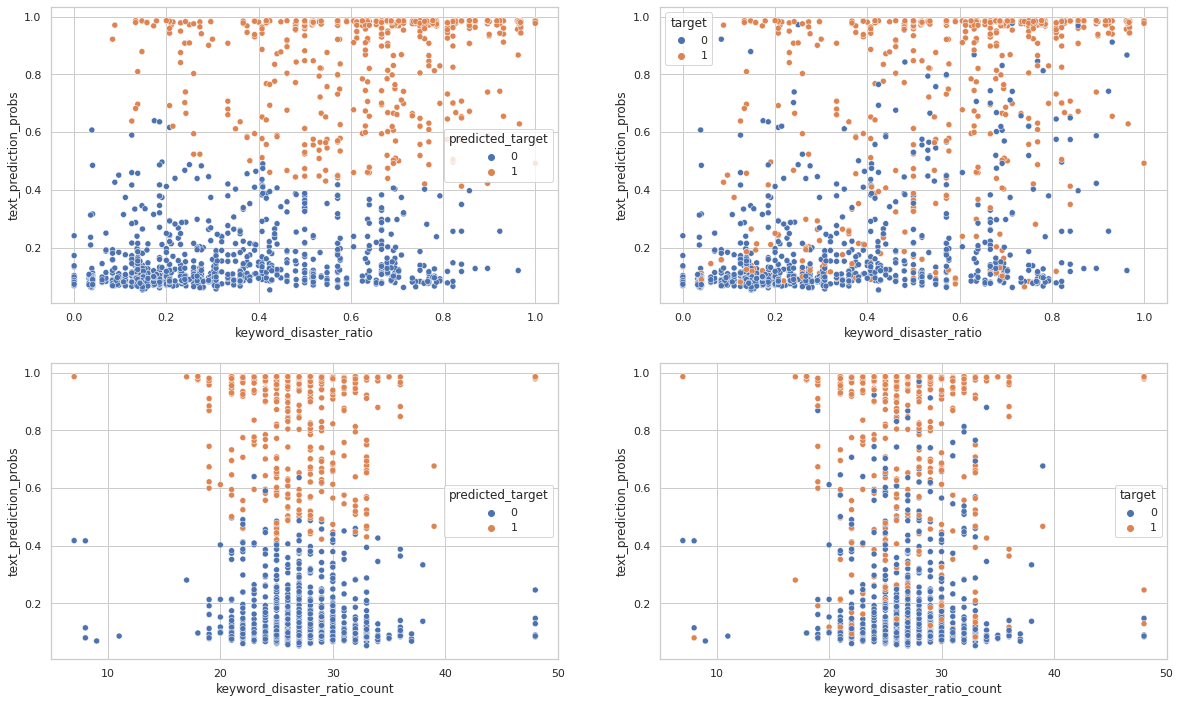

In [32]:
fig, axs = plt.subplots(2,2, figsize=(20,12))

sns.scatterplot(data=val_df, x="keyword_disaster_ratio", y="text_prediction_probs", hue="predicted_target",ax=axs[0, 0])
sns.scatterplot(data=val_df, x="keyword_disaster_ratio", y="text_prediction_probs", hue="target",ax=axs[0, 1])


sns.scatterplot(data=val_df, x="keyword_disaster_ratio_count", y="text_prediction_probs", hue="predicted_target",ax=axs[1, 0])
sns.scatterplot(data=val_df, x="keyword_disaster_ratio_count", y="text_prediction_probs", hue="target",ax=axs[1, 1])

In [33]:
test_predictions = best_overall['clf'].predict(test_x)

sample_submission["target"] = test_predictions

display(sample_submission.head(20))

sample_submission.to_csv("submission.csv", index=False)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
